In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/Dataset1_Customised"

In [4]:
data_dir = ROOT
train_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/Dataset1_Customised/train"
test_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/Dataset1_Customised/test"

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4936, 0.4809, 0.4205])
Calculated stds: tensor([0.1958, 0.1959, 0.2013])


In [6]:
pretrained_size = 224
pretrained_means = [0.4936, 0.4809, 0.4205]
pretrained_stds= [0.1958, 0.1959, 0.2013]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [7]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 5622
Number of validation examples: 625
Number of testing examples: 150


In [11]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [13]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

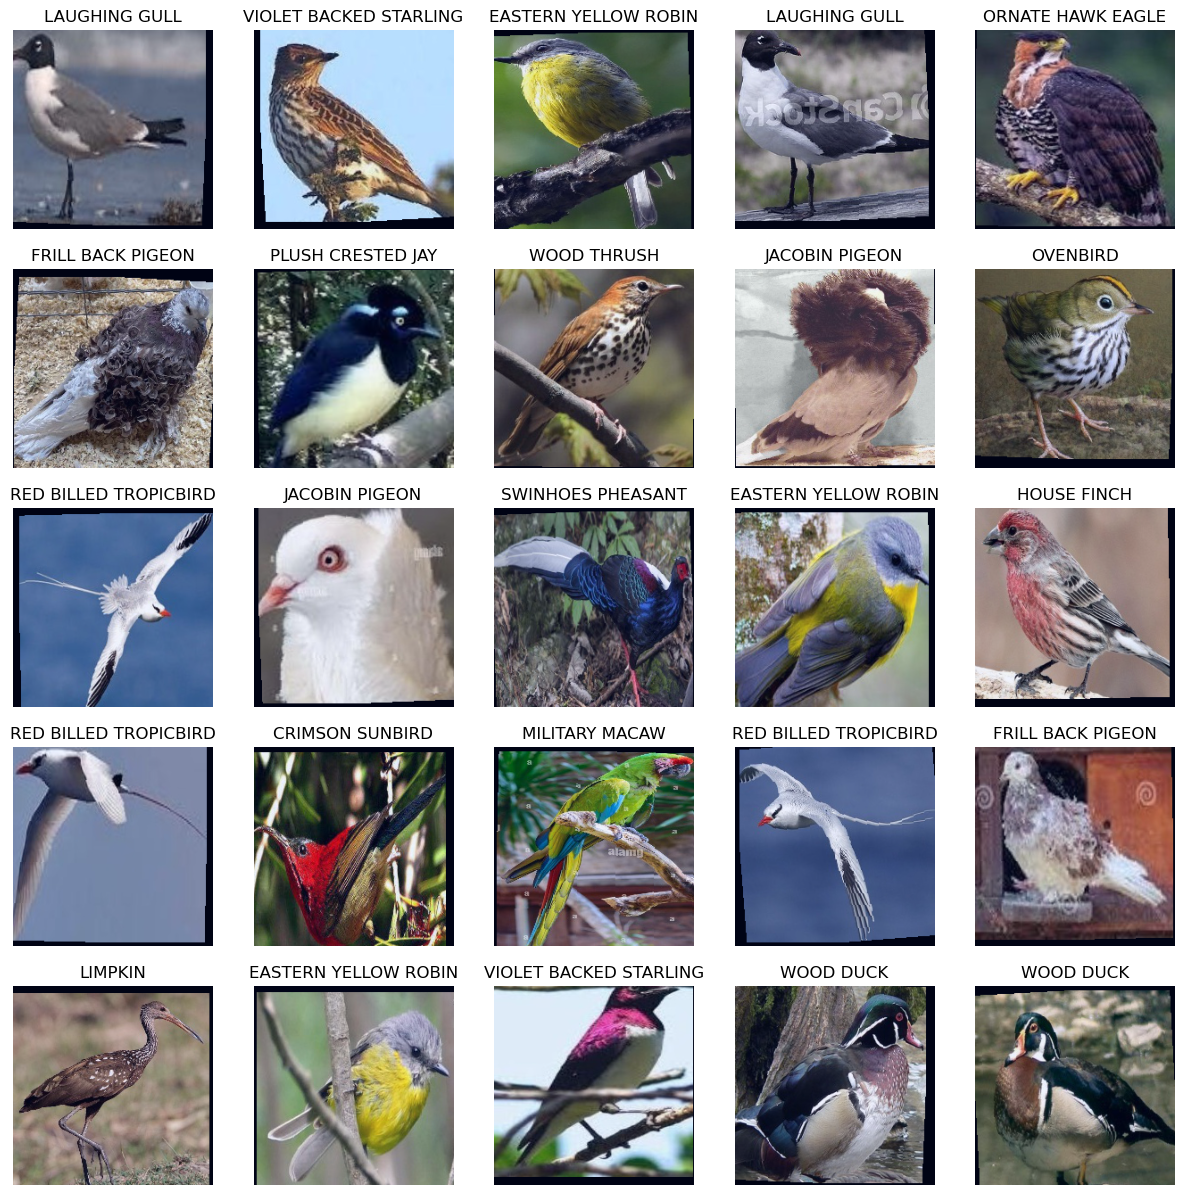

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [15]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

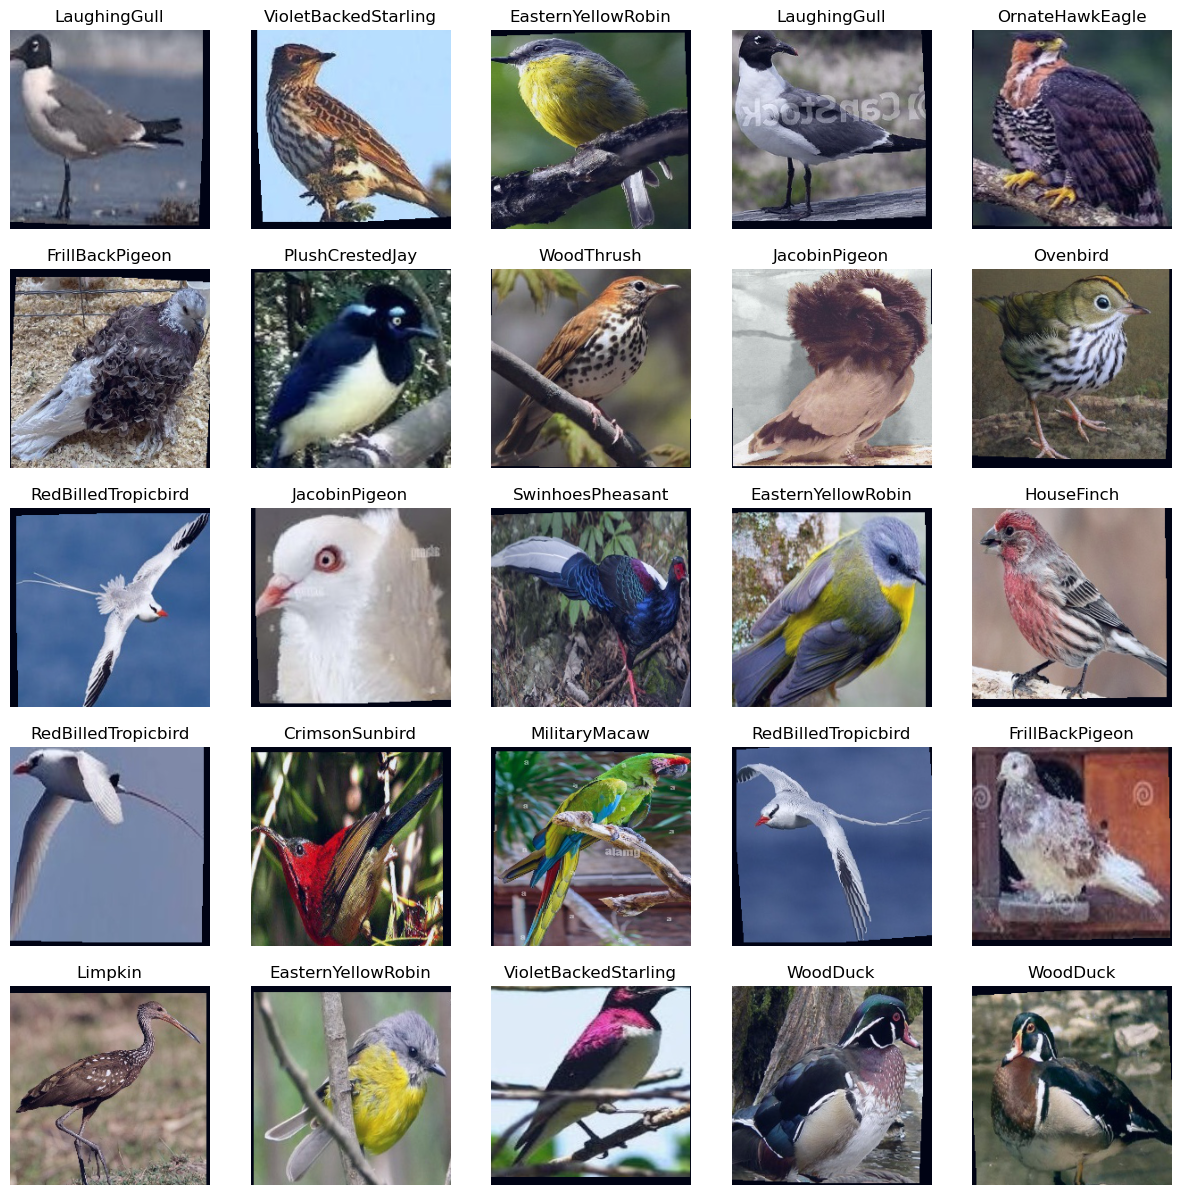

In [16]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [17]:
num_classes = 50

In [18]:
import torch
import torchvision.models as models

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=False) #Not TL

/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
     

The model has 138,357,544 trainable parameters


In [20]:
import os
import torch

# Create a new directory
save_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/Dataset1_Customised"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [21]:
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [24]:
import wandb
wandb.login()

wandb: Currently logged in as: mahekmaster. Use `wandb login --relogin` to force relogin


True

In [25]:
run_name = 'VGG-Dataset1-v2' #change this name everytime for every dataset, if either of the dataset or architecture changes, change the name
wandb.init(project="AIProject2023", name = run_name, reinit=True) #mode="disabled", id='" ", resume="must"

In [26]:
import time

train_losses = []
train_acc_list = []
valid_losses = []
valid_acc_list = []

num_epochs = 10
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # Training loop
    model.train()
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        #print(" Loss ", loss)
        #print(" Item ", loss.item())
        #print(" Train Loss ", train_loss)
        #print(" Divided", train_loss / images.size(0))
        wandb.log({'train_loss': loss.item()})
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in valid_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            wandb.log({'valid_loss': loss.item()})
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            valid_total += labels.size(0)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), run_name)

    # Calculate metrics
    train_loss = train_loss / len(train_iterator.dataset)
    valid_loss = valid_loss / len(valid_iterator.dataset)
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    

    wandb.log({'train_accuracy': train_accuracy})
    wandb.log({'valid_accuracy': valid_accuracy})
    
    #append values
    
    train_losses.append(train_loss)
    train_acc_list.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_acc_list.append(valid_accuracy)
   
    
    # Print metrics
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} took {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {valid_loss:.6f} | Val Accuracy: {valid_accuracy:.2f}%")

Epoch 1 took 56m 46s
Train Loss: 3.833419 | Train Accuracy: 3.27%
Val Loss: 3.423949 | Val Accuracy: 8.16%
Epoch 2 took 54m 60s
Train Loss: 3.229197 | Train Accuracy: 9.73%
Val Loss: 2.893308 | Val Accuracy: 16.00%
Epoch 3 took 54m 43s
Train Loss: 2.763578 | Train Accuracy: 19.83%
Val Loss: 2.433760 | Val Accuracy: 32.64%
Epoch 4 took 54m 36s
Train Loss: 2.314463 | Train Accuracy: 32.64%
Val Loss: 1.982316 | Val Accuracy: 44.48%
Epoch 5 took 53m 57s
Train Loss: 1.911981 | Train Accuracy: 44.15%
Val Loss: 1.696535 | Val Accuracy: 49.28%
Epoch 6 took 53m 52s
Train Loss: 1.605684 | Train Accuracy: 52.05%
Val Loss: 1.429228 | Val Accuracy: 59.68%
Epoch 7 took 55m 12s
Train Loss: 1.409219 | Train Accuracy: 58.43%
Val Loss: 1.195497 | Val Accuracy: 65.28%
Epoch 8 took 53m 58s
Train Loss: 1.190617 | Train Accuracy: 64.91%
Val Loss: 1.160234 | Val Accuracy: 66.56%
Epoch 9 took 53m 39s
Train Loss: 1.034795 | Train Accuracy: 69.09%
Val Loss: 1.071657 | Val Accuracy: 68.64%
Epoch 10 took 54m 44s


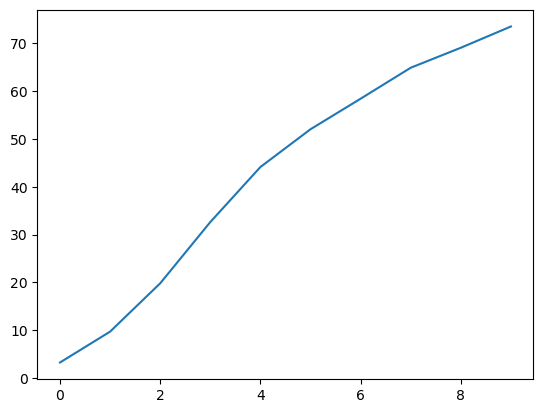

In [27]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_list)), train_acc_list)

In [28]:
# Testing loop
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_test_accuracy = 0
    total_test_count = 0
    for images, labels in test_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_accuracy += (predicted == labels).sum().item()
        total_test_count += images.size(0)

    average_test_loss = total_test_loss / total_test_count
    average_test_accuracy = total_test_accuracy / total_test_count

print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy:.4f}")



Test Loss: 0.6589, Test Accuracy: 0.8133


In [29]:
# Evaluation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_count = 0
    for images, labels in valid_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_val_accuracy += (predicted == labels).sum().item()
        total_val_count += images.size(0)

    average_val_loss = total_val_loss / total_val_count
    average_val_accuracy = total_val_accuracy / total_val_count

print(f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")


Validation Loss: 1.0270, Validation Accuracy: 0.7072


In [30]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

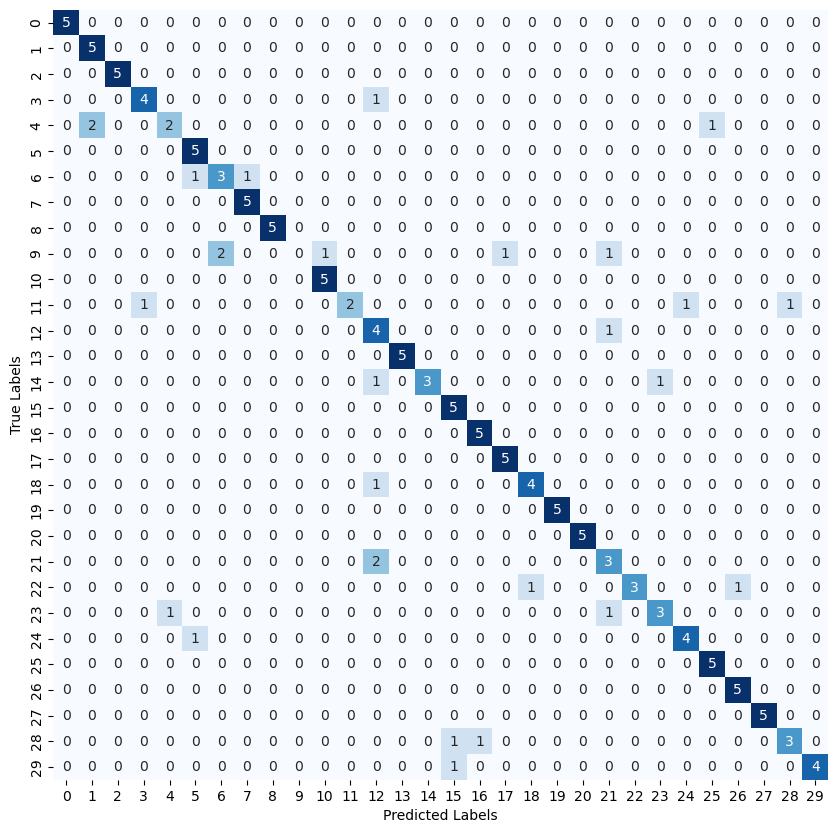

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
images, labels, probs = get_predictions(model, test_iterator)

# Get predicted labels
pred_labels = torch.argmax(probs, 1)

# Create confusion matrix
conf_mat = confusion_matrix(labels.view(-1), pred_labels.view(-1))

# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [32]:
from sklearn.metrics import classification_report

# Assuming you have defined 'labels', 'pred_labels' and 'classes' variables
print(classification_report(labels, pred_labels, target_names=classes))

                       precision    recall  f1-score   support

         CampoFlicker       1.00      1.00      1.00         5
          CaspianTern       0.71      1.00      0.83         5
       CrimsonSunbird       1.00      1.00      1.00         5
      D-ArnaudsBarbet       0.80      0.80      0.80         5
        DarkEyedJunco       0.67      0.40      0.50         5
   EasternYellowRobin       0.71      1.00      0.83         5
      FrillBackPigeon       0.60      0.60      0.60         5
GreaterPrairieChicken       0.83      1.00      0.91         5
           HouseFinch       1.00      1.00      1.00         5
        JacobinPigeon       0.00      0.00      0.00         5
         LaughingGull       0.83      1.00      0.91         5
              Limpkin       1.00      0.40      0.57         5
               Merlin       0.44      0.80      0.57         5
        MilitaryMacaw       1.00      1.00      1.00         5
      OrnateHawkEagle       1.00      0.60      0.75  

/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Define a function to extract features from a given layer of the model
def extract_features(model, layer, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)
            features.append(outputs.detach().numpy())
    features = np.vstack(features)
    return features

In [34]:
# Define the layer to extract features from
layer = model.classifier[1]

In [35]:
# Set the device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
torch.save(model.state_dict(), os.path.join(save_dir, run_name + '.pth'))